<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PAPER_EXPERT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: XXXX
# Journal: Expert System with Application 

## Abstract: XXXX

O objetivo deste notebook é mostrar que o uso de técnicas de imbalanced learning pode melhorar a acurácia de modelos preditivos de evasão. 

Na primeira parte do paper serão feitos dois modelos: xxx. 

Na segunda parte será utilizada a técnica Balanced Bagging (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html) com o core DT. 

Para cada modelo serão gerados as métricas: precision, accuracy, recall, ROC, confusion matrix e G-mean. Este último será utilizado para comparação entre modelos como indicado para problemas de dados desbalanceados (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf). 

Ao fim é feito o teste de p-value para confirmar se houve diferença estatística entre o desempenho dos modelos

In [0]:
#!pip install -U Skater

Import packages 

In [0]:
#import packages

#graphs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

#google drive
import os
from google.colab import drive

#data crawling
import numpy as np
import pandas as pd

#evalueting models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef

#selecionando atributos 
from sklearn.feature_selection import RFECV

#classic models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

#imbalanced
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import operator
from sklearn.base import clone
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

from imblearn.pipeline import make_pipeline as make_imb_pipeline

import collections
from collections import Counter 
from collections import OrderedDict

#show graphs in notebook
%matplotlib inline

Import database. The construct the database is available in https://github.com/tmedeirosb/modelo_ifrn_integrado/blob/master/versao_2/workflow_criando_base.ipynb 

In [3]:
#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


(8908, 33)

Functions to pre-process data (remove NaN, dummies transform),  and evaluate the model



In [0]:
#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

Define os atributos da base de dados e, caso ainda tenha valores NAN, substituti por -1

In [5]:
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

1    7369
0     349
Name: classe, dtype: int64


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,15,F,False,0,1,2,LAJ,1
10,61.0,0,100.0,60.0,0,100.0,0,False,0,1,B,A,Urbana,Pais,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino médio completo,Ensino médio completo,Parda,Ensino médio completo,Mãe,Não informado,15,M,True,0,2,5,CANG,2


Separa os dados em 25% de teste e 75% de treino. Os dois folds são estratificados de acordo com o balanceamento da classe de evasão, a fim de manter a proporção dos dados do conjunto original. 

Esse conjunto de dados será utilizado em todos os modelos

In [6]:
#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


5788
1930


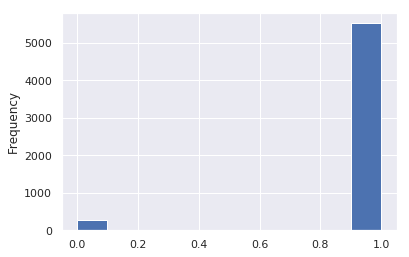

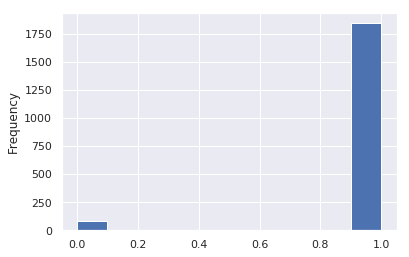

In [7]:
#visualizando distribuicao de dados 
plt.figure()
#sns.distplot(ytrain)
ytrain.plot.hist()
print(len(ytrain))

plt.figure()
#sns.distplot(ytest)
ytest.plot.hist()
print(len(ytest))

In [0]:
class ModelML:
  def __init__(self, model, hyperparameters=None, balance=""):
        self.base = model
        self.name = model.__class__.__name__+" "+balance        
        self.hyperparameters = hyperparameters
        self.best_attr = []
        self.balance = balance
        self.best_params = None
        self.best_score = None
        self.best_model = None
        
#cria lista de modelos que serao utilizados no trabalho
def make_list_model(balance=""):
  #DEFINICAO DOS MODELOS A SEREM TREINADOS
  par_DT = {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 3, 5],
            "max_leaf_nodes": [None, 5, 10, 20]
            }

  par_SVC = {
              "kernel": ['rbf'],  
              "C": [0.001, 0.01, 0.1, 1, 10],
            }

  par_LR = {
              "solver": ["newton-cg", "lbfgs", "liblinear"]
            }

  par_MLP = {
                  'solver': ['lbfgs'], 
                  'max_iter': [200],
                  'alpha': 10.0 ** -np.arange(1, 4), 
                  'hidden_layer_sizes':np.arange(5, 20, 3), 
                  'random_state':[0]
              }

  par_RF = {
                "max_features": ["auto"],
                'n_estimators': [10, 30, 100, 200, 300]
            }

  par_NB = {
              'alpha':np.linspace(0.1,1,10)
           }

  models = [ModelML(DecisionTreeClassifier(), par_DT, balance), #RFEC OK
            #ModelML(SVC(probability=True, gamma='auto'), par_SVC), #RFEC NO
            ModelML(LogisticRegression(solver="lbfgs"), par_LR, balance), #RFEC OK
            #ModelML(MLPClassifier(), par_MLP), #RFEC NO
            ModelML(RandomForestClassifier(n_estimators=10), par_RF, balance), #RFEC OK
            ModelML(BernoulliNB(), par_NB, balance) #RFEC OK
           ]
  
  return models
        
        
#seleciona os melhores atributos para cada modelo
def select_attr(models, Xtrain, ytrain, columns):
  #seleciona os melhores atributos por modelo
  for model in models:

      #if model.name in ['SVC', 'MLPClassifier']:
      #    continue

      print(model.name)
      print('-'*len(model.name))

      #seleciona os melhores atributos para cada modelo
      selector = RFECV(clone(model.base), cv=10, n_jobs=-1, scoring=make_scorer(geometric_mean_score))
      selector.fit(Xtrain, ytrain)

      best_columns = list(columns[selector.support_])
      #print("Best Columns \n{}\n".format(best_columns))    

      #salva os melhores atributos para o modelo
      model.best_attr = best_columns   

#ranking dos atributos pela frequencia que ocorreu para cada modelo
def show_ranking_attr(models):

  ranking_attr = []
  tmp = []

  #para cada modelo, recupera os melhores atributos
  for model in models:
    #print(model.best_attr)
    tmp.append(model.best_attr)

  #print(tmp)
  #ranking das features
  x = sum(tmp, [])
  counter = collections.Counter(x)
  sorted_dict = OrderedDict(sorted(counter.items(), key=lambda t: t[1], reverse=True))
  
  #cnt = 0
  #for k, v in sorted_dict.items():
  #    print(cnt, k, v)
  #    cnt = cnt + 1
      
  return sorted_dict

#seleciona o melhor conjunto de atributos (freq > 1)
def select_best_attr_comite(sorted_under, models):
  #selecionando os melhores atributos do comite

  #deve ter sido selecionado ao menos por duas tecnicas
  attr_2 = [k for k, v in sorted_under.items() if v > 1]
  print(attr_2)

  #max_freq = (max(sorted_under.values()))
  #attr_max = [k for k, v in sorted_under.items() if v == max_freq]
  #print(attr_max)

  #atualiza os melhores atributos
  for model in models:
    model.best_attr = attr_2
    

#treina cada modelo de acordo com os melhores atributos
def select_model_tun(Xtrain, Xtest, ytrain, ytest, models):    
    #treina o modelo de acordo com os atributos selecionados
    for model in models:    
        #se o modelo nao houve selecao de atributos, considera todos
        if len(model.best_attr) == 0:
          model.best_attr = Xtrain.columns            
                
        Xtrain_2 = Xtrain[model.best_attr]
        Xtest_2  = Xtest[model.best_attr]
        
        print(model.name)
        #print(model.best_attr)
        print('-'*len(model.name))         
        
        grid = GridSearchCV(model.base,
                            param_grid=model.hyperparameters,
                            cv=10, 
                            scoring=make_scorer(geometric_mean_score))
        
        grid.fit(Xtrain_2, ytrain)
        model.best_params = grid.best_params_
        model.best_score = grid.best_score_
        model.best_model = grid.best_estimator_
                
        print("Best Score: {}".format(model.best_score))
        print("Best Parameters: {}".format(model.best_params))        
          
def plot_comp_models(models):  
  results = []
  names = []
  
  for model in models:      
    results.append(model.cv_results)
    names.append(model.name)

  fig = plt.figure()
  fig.suptitle('Algorithm Comparison')
  fig.set_size_inches(11.7, 8.27)
  ax = fig.add_subplot(111)
  plt.boxplot( results )
  ax.set_xticklabels( names )
  plt.xticks(rotation=90)
  plt.show()
  
#plot roc curve
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')


def evaluating_models(models, Xtest, ytest, results):
  #avaliacao individual por modelo
  for model in models:        
      print('\n\n'+model.name)
      print('-'*len(model.name))

      print("Melhor Modelo")
      print(len(model.best_attr))
      print(model.best_model)
      
      #sim
      ypred = model.best_model.predict(Xtest[model.best_attr])
      
      #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
      #     AN | AP 
      # --------------
      # PN: TN | FN
      # PP: FP | TP

      #Text summary of the precision, recall, F1 score for each class
      #precision = TP/(TP+FP); TN/(TN+FN) 
      #recall    = TP/(TP+FN); TN/(TN+FP)
      class_report = classification_report(ytest, ypred, output_dict=True)
      #print(class_report.report)

      #matriz
      mat = confusion_matrix(ytest, ypred)
      sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
      plt.xlabel('true label')
      plt.ylabel('predicted label');

      #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
      #print(tp)
      #print(tn)
      #print(fn)
      #print(fp)
      #print( tn/(tn+fp) )

      #CURVA ROC
      fig = plt.figure()
      y_probas = cross_val_predict(model.best_model, Xtest, ytest, cv=10, method="predict_proba") 

      #TODO COLOCAR DA CLASSE NEGATIVA
      y_scores = y_probas[:, 1]   # score = proba of positive class 
      fpr, tpr, thresholds = roc_curve(ytest, y_scores)

      plot_roc_curve(fpr, tpr) 
      plt.show()
      auc = roc_auc_score(ytest, y_scores)
      #print("AUC: %f" % auc)            

      #GMEAN
      #print("G-MEAN: %f" % geometric_mean_score(ytest, ypred))            
      g = geometric_mean_score(ytest, ypred)
            
      #atualiza o frame de results
      results = results.append( pd.DataFrame({'name' : [model.name], 
                                    'precision' : [class_report["1"]["precision"]], 
                                    'recall' : [class_report["1"]["recall"]], 
                                    'f1' : [class_report["1"]["f1-score"]], 
                                    'auc' : [auc], 
                                    'g-mean' : [g]
                                    }
                              ), ignore_index=True
                                  
                    )      
      
  # boxplot algorithm comparison
  #plot_comp_models(models)
  
  #return(results, names)
  print(results)
  return results

DecisionTreeClassifier 
-----------------------
Best Score: 0.6593752707599174
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 20}
LogisticRegression 
-------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Score: 0.5368841192922973
Best Parameters: {'solver': 'newton-cg'}
RandomForestClassifier 
-----------------------
Best Score: 0.576824569571628
Best Parameters: {'max_features': 'auto', 'n_estimators': 10}
BernoulliNB 
------------
Best Score: 0.6766361737031936
Best Parameters: {'alpha': 0.8}


DecisionTreeClassifier 
-----------------------
Melhor Modelo
151
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


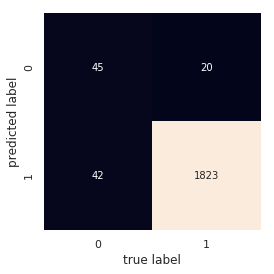

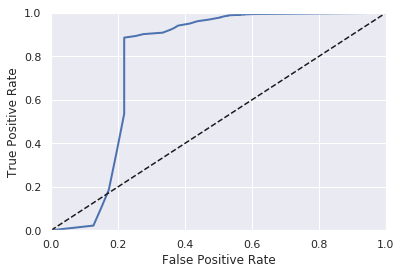



LogisticRegression 
-------------------
Melhor Modelo
151
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)


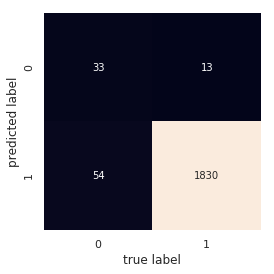

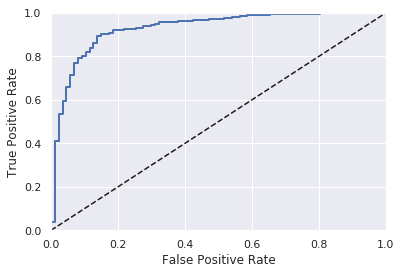



RandomForestClassifier 
-----------------------
Melhor Modelo
151
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


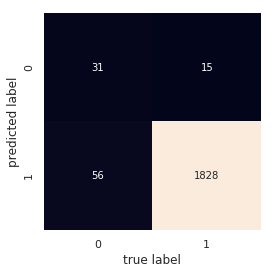

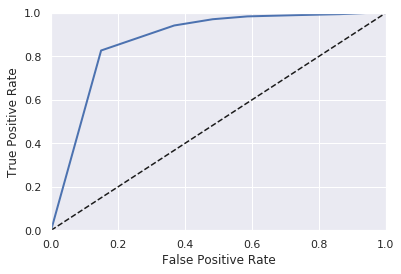



BernoulliNB 
------------
Melhor Modelo
151
BernoulliNB(alpha=0.8, binarize=0.0, class_prior=None, fit_prior=True)


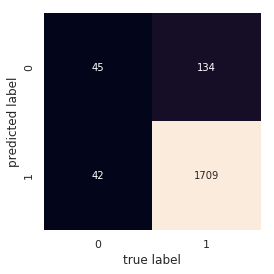

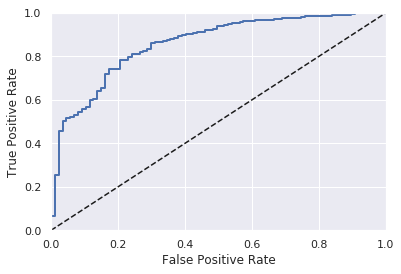

                      name  precision    recall        f1       auc    g-mean
0  DecisionTreeClassifier    0.977480  0.989148  0.983279  0.782055  0.715282
1      LogisticRegression    0.971338  0.992946  0.982023  0.928215  0.613706
2  RandomForestClassifier    0.970276  0.991861  0.980950  0.876441  0.594493
3             BernoulliNB    0.976014  0.927292  0.951029  0.857647  0.692556


In [9]:
#modelo sem balanceamento e com todos os atributos 
models_sem = make_list_model()

#seleciona o melhor modelo
select_model_tun(Xtrain, Xtest, ytrain, ytest, models_sem)

#avaliacao dos modelos 
results = pd.DataFrame({'name' : [], 'precision' : [], 'recall' : [], 'f1' : [], 'auc' : [], 'g-mean' : []})
results = evaluating_models(models_sem, Xtest, ytest, results)

DecisionTreeClassifier UNDER
----------------------------
LogisticRegression UNDER
------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

RandomForestClassifier UNDER
----------------------------
BernoulliNB UNDER
-----------------
['conceito_I', 'conceito_R', 'conceito_O', 'conceito_freq_R', 'descricao_pai_escolaridade_Não conhece', 'descricao_responsavel_financeiro_Irmão(ã)', 'LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'artificial', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_freq_I', 'descricao_area_residencial_Comunidade Quilombola', 'descricao_area_residencial_Não informado', 'descricao_companhia_domiciliar_Não informado', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_companhia_domiciliar_Sozinho(a)', 'descricao_estado_civil_Divorciado(a)', 'descricao_estado_civil_Não declarado', 'descricao_estado_civil_União Es

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.8824509463749743
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 10}
LogisticRegression UNDER
------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Score: 0.8634781572162804
Best Parameters: {'solver': 'lbfgs'}
RandomForestClassifier UNDER
----------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.8783284483598377
Best Parameters: {'max_features': 'auto', 'n_estimators': 300}
BernoulliNB UNDER
-----------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.8356241502678443
Best Parameters: {'alpha': 0.9}


DecisionTreeClassifier UNDER
----------------------------
Melhor Modelo
94
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


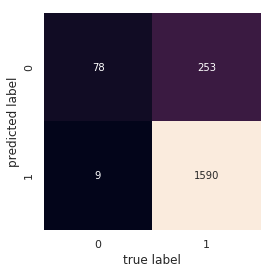

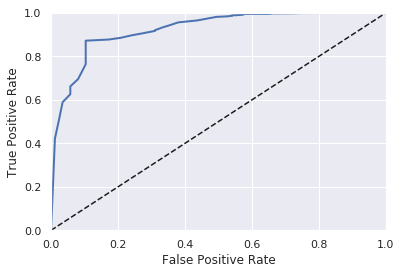



LogisticRegression UNDER
------------------------
Melhor Modelo
94
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

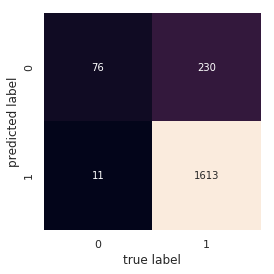

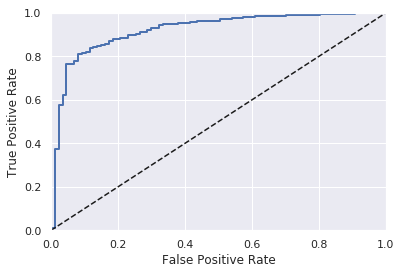



RandomForestClassifier UNDER
----------------------------
Melhor Modelo
94
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


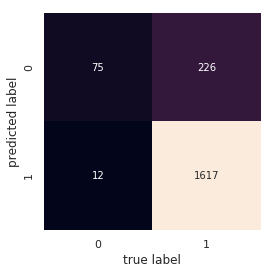

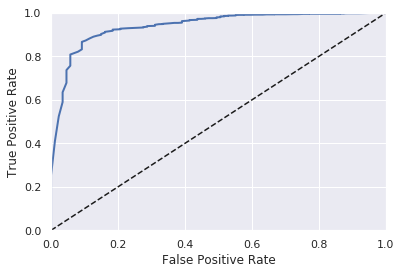



BernoulliNB UNDER
-----------------
Melhor Modelo
94
BernoulliNB(alpha=0.9, binarize=0.0, class_prior=None, fit_prior=True)


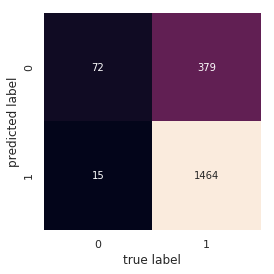

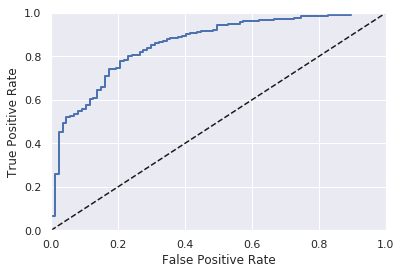

                           name  precision    recall        f1       auc  \
0       DecisionTreeClassifier    0.977480  0.989148  0.983279  0.782055   
1           LogisticRegression    0.971338  0.992946  0.982023  0.928215   
2       RandomForestClassifier    0.970276  0.991861  0.980950  0.876441   
3                  BernoulliNB    0.976014  0.927292  0.951029  0.857647   
4  DecisionTreeClassifier UNDER   0.994371  0.862724  0.923881  0.924106   
5      LogisticRegression UNDER   0.993227  0.875203  0.930487  0.920588   
6  RandomForestClassifier UNDER   0.992634  0.877374  0.931452  0.939641   
7             BernoulliNB UNDER   0.989858  0.794357  0.881397  0.857840   

     g-mean  
0  0.715282  
1  0.613706  
2  0.594493  
3  0.692556  
4  0.879475  
5  0.874383  
6  0.869688  
7  0.810801  


In [10]:
#SELECIONA OS MELHORES ATRIBUTOS PARA O UNDER SAMPLE
models_under = make_list_model("UNDER")

#balanceamento de dados
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_under = pd.DataFrame(X_under)
X_under.columns = Xtrain.columns

#seleciona os melhores atributos
select_attr(models_under, X_under, y_under, Xtrain.columns)

#ranking dos melhores atributos
sorted_under = show_ranking_attr(models_under)

#selecionando os melhores atributos
select_best_attr_comite(sorted_under, models_under)

#seleciona melhor modelo com os atributos selecionados
select_model_tun(X_under, Xtest, y_under, ytest, models_under)

#avalia modelos
results = evaluating_models(models_under, Xtest, ytest, results)

DecisionTreeClassifier SMOTE
----------------------------
LogisticRegression SMOTE
------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

RandomForestClassifier SMOTE
----------------------------
BernoulliNB SMOTE
-----------------
['MatemticaI120H_dependencia', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'possui_necessidade_especial', 'qnt_pc', 'conceito_I', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Rural', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Edificações', 'descricao_historico_Técnico de Nível Médio em Mecânica', 'descricao_historico_Técnico de Nível Médio em Meio Ambiente', 'descricao_historico_Técnico de Nível Médio em Multimídia', 'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros', 'descricao_historico_Técnico em Programação de Jogos Digitais', 'descricao_imovel_Financiado

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Score: 0.8994012463927654
Best Parameters: {'solver': 'newton-cg'}
RandomForestClassifier SMOTE
----------------------------
Best Score: 0.9789224823354636
Best Parameters: {'max_features': 'auto', 'n_estimators': 100}
BernoulliNB SMOTE
-----------------
Best Score: 0.9127603502997977
Best Parameters: {'alpha': 0.1}


DecisionTreeClassifier SMOTE
----------------------------
Melhor Modelo
145
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


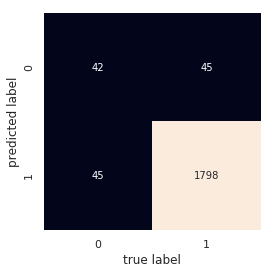

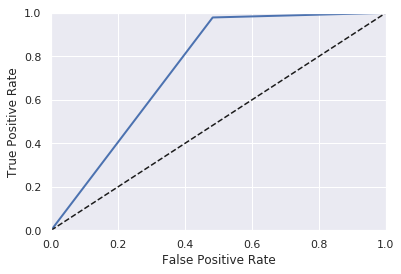



LogisticRegression SMOTE
------------------------
Melhor Modelo
145
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)


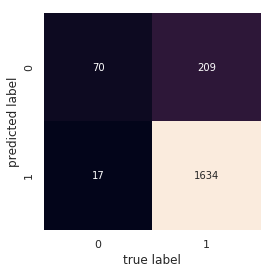

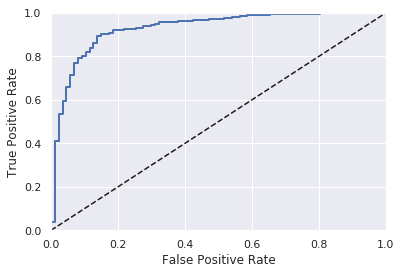



RandomForestClassifier SMOTE
----------------------------
Melhor Modelo
145
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


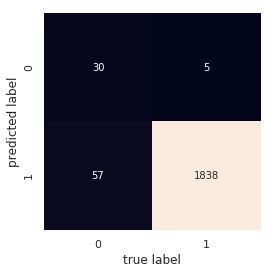

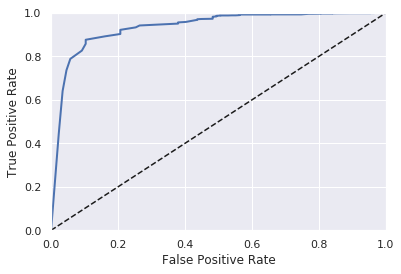



BernoulliNB SMOTE
-----------------
Melhor Modelo
145
BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)


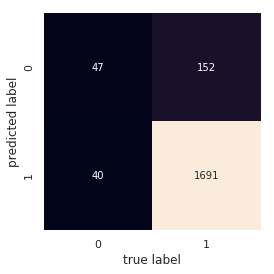

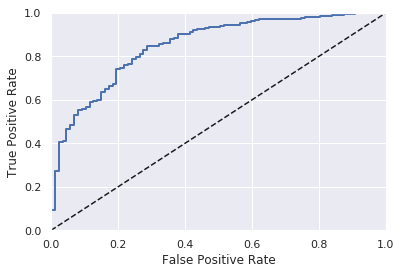

                            name  precision    recall        f1       auc  \
0        DecisionTreeClassifier    0.977480  0.989148  0.983279  0.782055   
1            LogisticRegression    0.971338  0.992946  0.982023  0.928215   
2        RandomForestClassifier    0.970276  0.991861  0.980950  0.876441   
3                   BernoulliNB    0.976014  0.927292  0.951029  0.857647   
4   DecisionTreeClassifier UNDER   0.994371  0.862724  0.923881  0.924106   
5       LogisticRegression UNDER   0.993227  0.875203  0.930487  0.920588   
6   RandomForestClassifier UNDER   0.992634  0.877374  0.931452  0.939641   
7              BernoulliNB UNDER   0.989858  0.794357  0.881397  0.857840   
8   DecisionTreeClassifier SMOTE   0.975583  0.975583  0.975583  0.748040   
9       LogisticRegression SMOTE   0.989703  0.886598  0.935318  0.928215   
10  RandomForestClassifier SMOTE   0.969921  0.997287  0.983414  0.933991   
11             BernoulliNB SMOTE   0.976892  0.917526  0.946279  0.850668   

In [11]:
#SELECIONA OS MELHORES ATRIBUTOS PARA O SMOTE SAMPLE
models_smote = make_list_model("SMOTE")

#balanceamento de dados
rsm = SMOTE(random_state=42)
X_smote, y_smote = rsm.fit_resample(Xtrain, ytrain)

#mantem em formato de dataframe
X_smote = pd.DataFrame(X_smote)
X_smote.columns = Xtrain.columns

#seleciona os melhores atributos
select_attr(models_smote, X_smote, y_smote, Xtrain.columns)

#ranking dos melhores atributos
sorted_smote = show_ranking_attr(models_smote)

#selecionando os melhores atributos
select_best_attr_comite(sorted_smote, models_smote)

#treina o modelo com os melhores atributos
select_model_tun(X_smote, Xtest, y_smote, ytest, models_smote)

#avalia os modelos
results = evaluating_models(models_smote, Xtest, ytest, results)

,name,precision,recall,f1,auc,g-mean
0,DecisionTreeClassifier,0.977480,0.989148,0.983279,0.782055,0.715282
1,LogisticRegression,0.971338,0.992946,0.982023,0.928215,0.613706
2,RandomForestClassifier,0.970276,0.991861,0.980950,0.876441,0.594493
3,BernoulliNB,0.976014,0.927292,0.951029,0.857647,0.692556
4,DecisionTreeClassifier UNDER,0.994371,0.862724,0.923881,0.924106,0.879475
5,LogisticRegression UNDER,0.993227,0.875203,0.930487,0.920588,0.874383
6,RandomForestClassifier UNDER,0.992634,0.877374,0.931452,0.939641,0.869688
7,BernoulliNB UNDER,0.989858,0.794357,0.881397,0.857840,0.810801
8,DecisionTreeClassifier SMOTE,0.975583,0.975583,0.975583,0.748040,0.686273
9,LogisticRegression SMOTE,0.989703,0.886598,0.935318,0.928215,0.844603


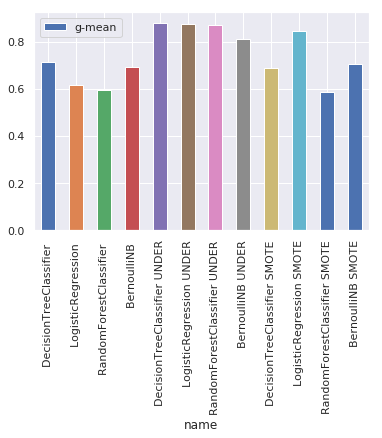

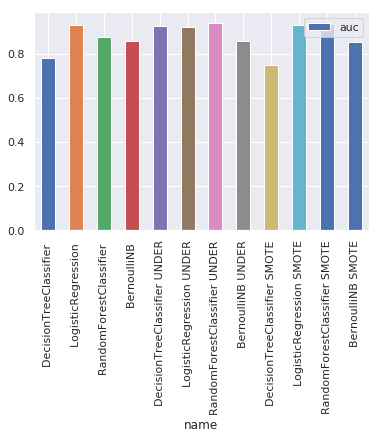

In [12]:
#comparando todos os modelos
#all_models = models_sem + models_under + models_smote
#plot_comp_models(all_models)

results.plot.bar(x='name', y='g-mean', rot=90)
results.plot.bar(x='name', y='auc', rot=90)

results

In [13]:
#otimizacao de quantidade de atributos

un = len(models_under[0].best_attr)
sm = len(models_smote[0].best_attr)
no = len(models_sem[0].best_attr)

print(un)
print(sm)
print(no)

print(1-un/no)
print(1-sm/no)
print(1-un/sm)



94
145
151
0.3774834437086093
0.039735099337748325
0.3517241379310345


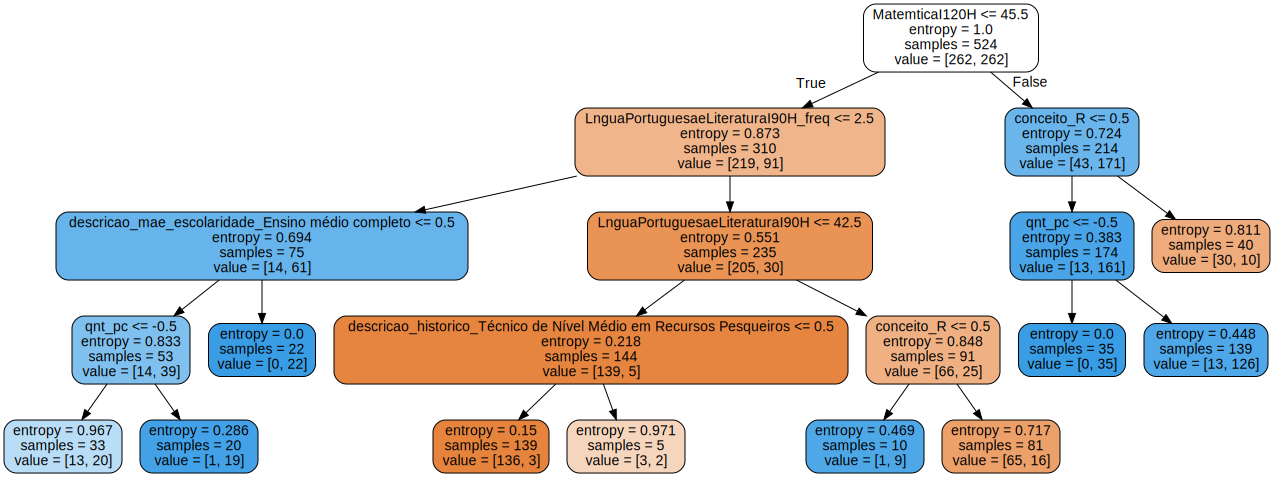

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(models_under[0].best_model, out_file=None
   , feature_names=models_under[0].best_attr
   , filled = True
   , rounded=True))
               
display(SVG(graph.pipe(format='svg')))



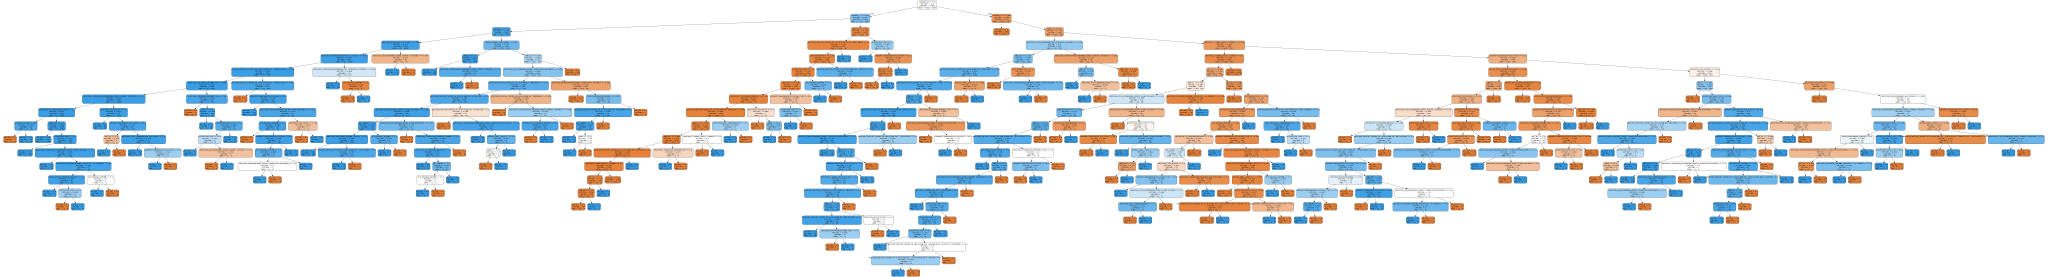

In [15]:
graph = Source(tree.export_graphviz(models_smote[0].best_model, out_file=None
   , feature_names=models_smote[0].best_attr
   , filled = True
   , rounded=True))
               
display(SVG(graph.pipe(format='svg')))



Feature COEF:


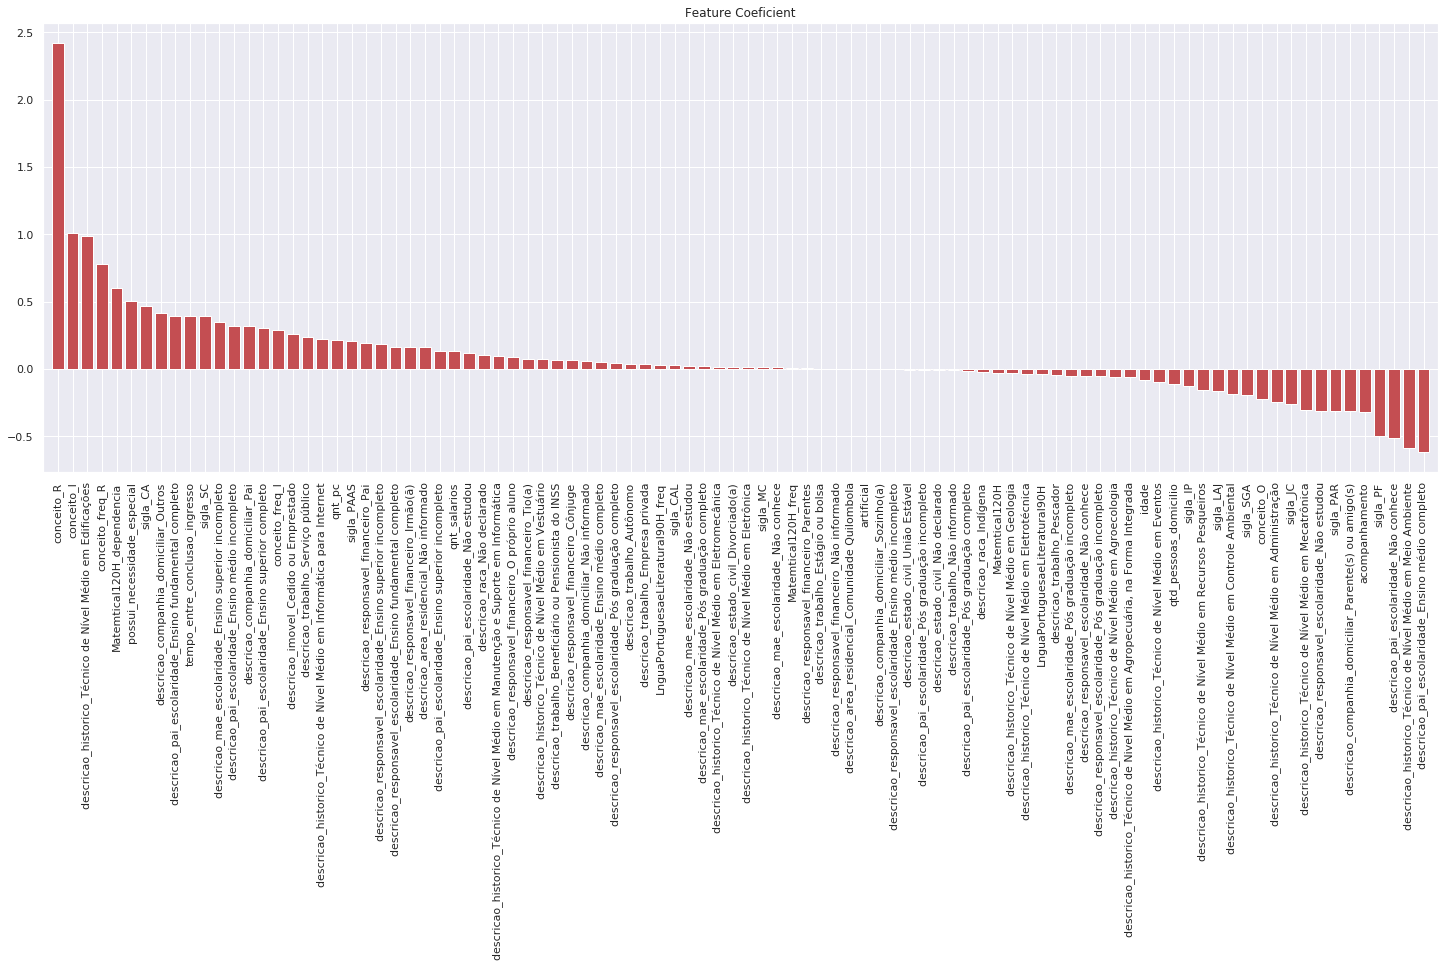

In [16]:
#TESTE PARA FEATURES IMPORTANCE LOGISTIC

m = models_under[1]

#mean
importances = m.best_model.coef_[0]*-1

#indices
indices = np.argsort(importances)[::-1]

print("Feature COEF:")

# Plot the feature importances of the forest
fig = plt.figure()
fig.set_size_inches(25.0, 8.27)
plt.title("Feature Coeficient")
plt.bar(range(Xtest[m.best_attr].shape[1]), importances[indices], color="r", align="center")
#plt.xticks(range(Xtest.shape[1]), indices)
plt.xticks(range(Xtest[m.best_attr].shape[1]), Xtest[m.best_attr].columns[indices])
#ax.set_xticklabels( names )
plt.xticks(rotation=90)
plt.xlim([-1, Xtest[m.best_attr].shape[1]])
plt.show()

2019-04-21 18:12:40,362 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[94/94] features ████████████████████ Time elapsed: 32 seconds

2019-04-21 18:13:13,080 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[94/94] features ████████████████████ Time elapsed: 37 seconds

2019-04-21 18:13:51,235 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[94/94] features ████████████████████ Time elapsed: 48 seconds

2019-04-21 18:14:40,175 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[94/94] features ████████████████████ Time elapsed: 37 seconds

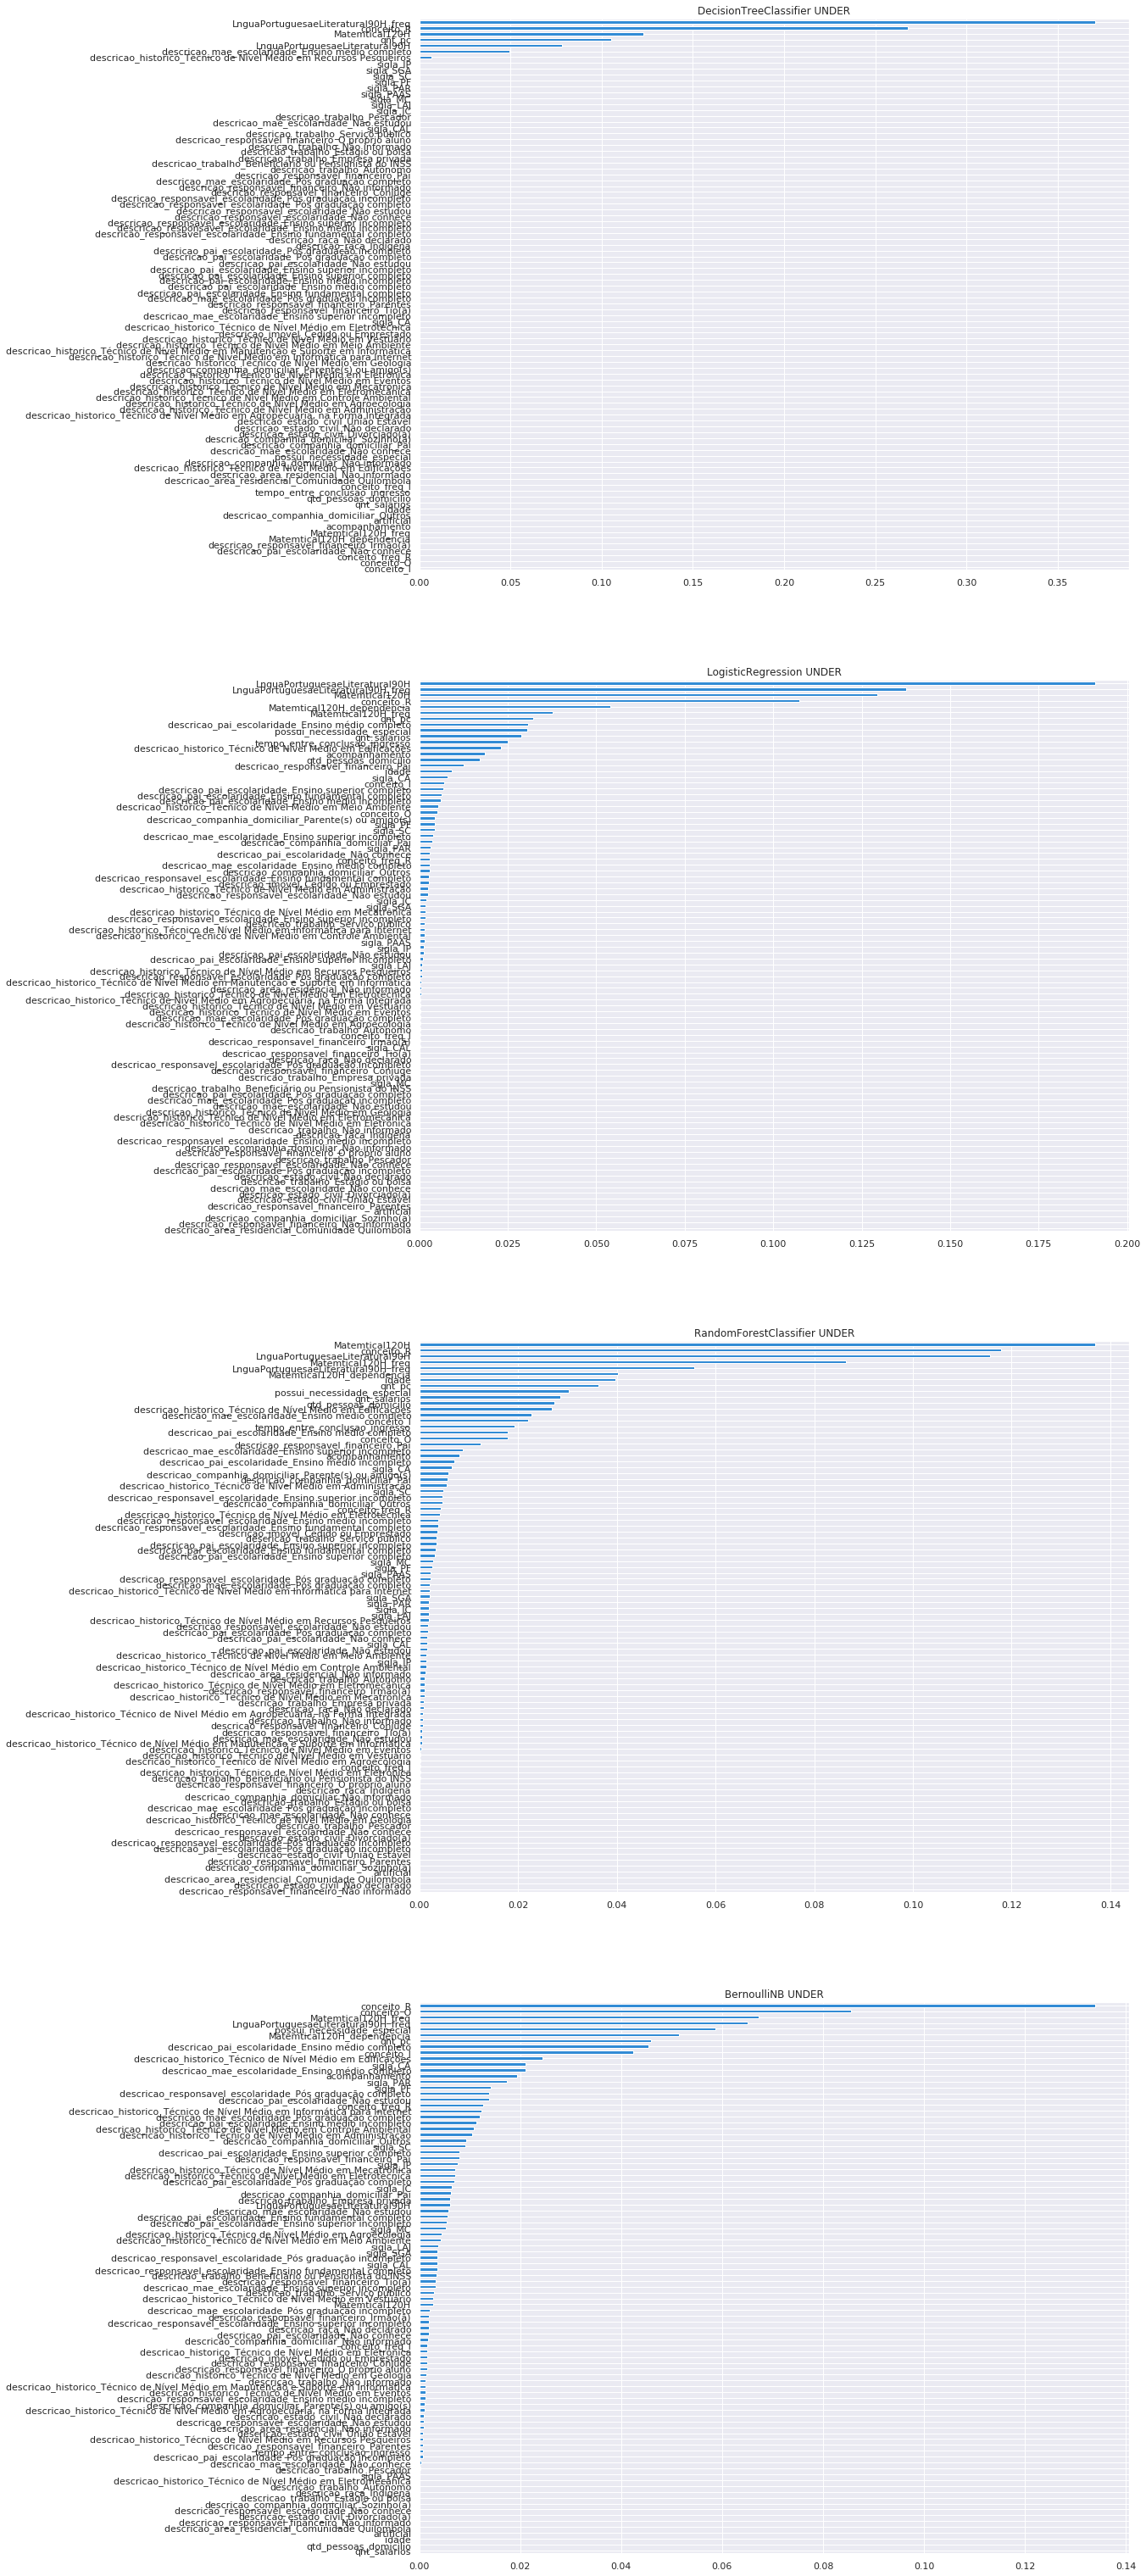

In [34]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# Ensemble Classifier does not have feature importance enabled by default
f, axes = plt.subplots(4, 1, figsize = (10, 40))

ax_dict = {
    'DecisionTreeClassifier UNDER':axes[0],
    'LogisticRegression UNDER':axes[1],
    'RandomForestClassifier UNDER':axes[2],
    'BernoulliNB UNDER':axes[3]
}	

interpreter = Interpretation(Xtest[m.best_attr], feature_names=m.best_attr)

for model in models_under:
    pyint_model = InMemoryModel(model.best_model.predict_proba, examples=Xtest[model.best_attr])
    ax = ax_dict[model.name]
    interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=True, ax=ax)
    ax.set_title(model.name)

In [0]:
"""
#TEST FEATURE IMPORTANCE LOGISTIC

#indices
sorted_coef = importances[indices]

my_list = [i for i in indices if importances[i] > 0]
#print(my_list)
#print(Xtest.iloc[:, my_list])

print("Feature COEF:")

# Plot the feature importances of the forest
fig = plt.figure()
fig.set_size_inches(20.0, 8.27)
plt.title("Feature Coeficient")
plt.bar(range(Xtest.iloc[:, my_list].shape[1]), importances[my_list], color="r", align="center")
#plt.xticks(range(Xtest.shape[1]), indices)
plt.xticks(range(Xtest.iloc[:, my_list].shape[1]), Xtest.columns[my_list])
#ax.set_xticklabels( names )
plt.xticks(rotation=90)
plt.xlim([-1, Xtest.iloc[:, my_list].shape[1]])
plt.show()
"""

In [0]:
"""
#FEATURE IMPORTANCE 

#g = sns.distplot(importances[indices], hist_kws=dict(cumulative=True),
#             kde_kws=dict(cumulative=True))
#g.set(xticklabels=Xtest.columns[indices])

arr_cum = []
cum = 0
for f in range(Xtest.iloc[:, my_list].shape[1]):
  cum = cum + importances[my_list[f]]
  arr_cum.append(cum)
  #print("%d. feature [%s] (%f) - Cumulative: %f" % (f + 1, Xtest.columns[indices[f]], importances[indices[f]], cum))
  

print(importances[my_list])
print(len(importances[my_list]))
print(len(arr_cum))
  

fig, ax = plt.subplots()
fig.set_size_inches(25.0, 8.27)
plt.title("Feature importances cumulative")

#plt.xticks(range(Xtest.shape[1]), Xtest.columns[indices])
plt.xticks(rotation=90)
plt.xticks(range(Xtest.iloc[:, my_list].shape[1]), Xtest.columns[my_list])
#plt.bar(range(Xtest.iloc[:, my_list].shape[1]), importances[my_list], color="r", align="center")
plt.bar(range(Xtest.iloc[:, my_list].shape[1]), arr_cum, color="r", align="center")
"""

##Utilizando técnicas robustas ao desbalanceamento

In [0]:
"""
#BalancedBaggingClassifier

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}

grid = GridSearchCV(BalancedBaggingClassifier(base_estimator=tree),
                    param_grid=parameters,
                    cv=10, 
                    verbose=1,
                    n_jobs = -1,
                    scoring=make_scorer(geometric_mean_score))

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

cv_results = model_selection.cross_val_score(ensemble, Xtest, ypred_ensemble, 
                                             cv=model_selection.KFold(
                                                 n_splits=10, random_state=42),
                                                 scoring=make_scorer(geometric_mean_score))
                                             #scoring='recall_macro')
                                             #scoring='accuracy')

results.append(cv_results)
names.append('Balanced Bagging')

msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
print(msg)

# boxplot algorithm comparison
plot_alg_comp(results, names)
"""